## CSE595 Homework 1 : Logistic Regression Implementation

In [1]:
import pandas
import re
from collections import Counter
import numpy as np
from scipy import sparse
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [4]:
%pip install torch
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Function to load stop words from NLTK Github Repo to be removed
def load_stopwords():
    f = open("stopwords.txt")
    words = f.readlines()
    stopwords = set()
    for i in words:
        i = i.strip()
        stopwords.add(i)
    return stopwords

stopwords = load_stopwords()

### Part 1 : Representing Text Data

In [3]:
# tokenizes purely by using whitespace
def tokenize (sentence : str):
    tokens = sentence.split()
    return tokens

In [4]:
# tokenizing by ignoring capitalization, removing stop words as well as all punctuations
def better_tokenize(text : str):
    # store unique tokens in tokens
    tokens = []
    # convert entire text into lowercase
    lowercase = text.lower()
    # find all possible words and all possible punctuations as their own tokens
    words = re.findall(r"\w+|[,.!?#\r\n$%;:()\"']", lowercase)

    for word in words:
        if word not in stopwords:
            tokens.append(word)
    return tokens

In [5]:
# build the vocabulary with a minimum word frequency of 250 along with a column mapping
def build_vocab(token_docs: list):
    vocab, all_tokens = [], []
    vocab_indices = {}
    for doc in token_docs:
        all_tokens.extend(doc)

    # returns frequences of tokens across all documents
    frequencies = Counter(all_tokens)

    i = 0
    for freq in frequencies:
    #   if above certain threshold, add to vocab
        if frequencies[freq] >= 250:
            vocab.append(freq)
            vocab_indices[freq] = i
            i += 1

    return set(vocab), vocab_indices

# create term document matrix
def create_sparse_matrix(documents : list, tokenizer_func):
    tokenized_docs = []
    for doc in documents:
        tokens = tokenizer_func(doc)
        tokenized_docs.append(tokens)
    vocab, indices = build_vocab(tokenized_docs)

    dense_matrix = []
    for doc in tokenized_docs:
        row = [0] * len(vocab)
        for token in doc:
            if token in vocab:
                row[indices[token]] += 1
        dense_matrix.append(row)

    np_arr = np.array(dense_matrix)
    sparse_td_matrix = sparse.csr_matrix(np_arr)

    return sparse_td_matrix, indices

# create a vector from a singular document of text
def create_document_vector(text, indices, tokenizer_func, numpy=True):
    tokens = tokenizer_func(text)
    # extra feature for bias in the case of numpy though we don't need it for pytorch
    if numpy:
        row = [0] * (len(indices) + 1)
    else: 
        row = [0] * (len(indices))
    for token in tokens:
        if token in indices:
            row[indices[token]] += 1
    # one extra feature to account for bias
    row[-1] = 1
    return np.array(row)

# convert boolean dataframe of class labels into numpy array of integers
def create_class_vector(class_labels):
    return np.array(class_labels, dtype=int)


#### Testing Tokenization

In [6]:
df = pandas.read_csv("train.csv")
better_tokenize(df['generation'][0])

['"',
 'conjuring',
 '"',
 'one',
 'thrilling',
 'horror',
 'film',
 'come',
 'recent',
 'times',
 '.',
 '"',
 'sinister',
 '"',
 'one',
 'scariest',
 'films',
 'watched',
 '.',
 'since',
 "'",
 'based',
 '"',
 'true',
 'events',
 '"',
 ',',
 'makes',
 'even',
 'interesting',
 '.',
 "'",
 'quite',
 'give',
 'full',
 '10',
 'star',
 'rating',
 'quite',
 'jump',
 'scares',
 ',',
 'least',
 'good',
 'portion',
 'jump',
 'scares',
 'add',
 'atmosphere',
 'movie',
 '.',
 'first',
 'time',
 'watcher',
 'movie',
 ',',
 'certainly',
 'disturb',
 '.',
 'doesn',
 "'",
 'stick',
 'like',
 '"',
 'sinister',
 '"',
 'long',
 ',',
 'conjuring',
 'fun',
 'watch',
 'always',
 'love',
 'coming',
 'back',
 'rewatch',
 'every',
 '.']

In [7]:
documents_test = ["I like the cat!", "the cat eats.", "i saw this cat and it was adorable i like it so much"]
# matrix, indices = create_sparse_matrix(df["generation"])

print(create_class_vector(df['label'].values))

# print(matrix)
# print(indices)

[0 0 0 ... 1 0 0]


### Part 2 : Logistic Regression w numpy

In [7]:
# Defining sigmoid function that takes in a np array/vector
def sigmoid(x):
    result = 1/(1+np.exp(-x))
    return result

# weights is our beta coefficients, x is the feature vector of a document and y is the ground truth of a document
def log_likelihood(y, predicted_y):
    a = y * predicted_y
    b = np.log(1 + np.exp(predicted_y))
    return a - b

# compute the gradient for a specific x vector, beta coefficients and ground truth y
def compute_gradient(x, y, predicted_y):
    gradient = (sigmoid(predicted_y) - y) * x
    return gradient

In [8]:
# logistic regression with X matrix each row is a feature vector, Y vector, rate of learning and number of steps
def logistic_regression(X, Y, learning_rate, num_step, epochs = 1, plot=20):
    print(X.shape)
    # Adding a column of ones as bias vector
    bias = np.array([1] * X.shape[0]).reshape(-1, 1)
    sparse_bias = sparse.csr_matrix(bias)
    # horizontally stacking training matrix with bias vector
    X = sparse.hstack([X, sparse_bias], format="csr")

    beta = [0] * X.shape[1]
    # beta values - vector of coefficients initialized to zero
    beta = np.array(beta)

    log_likelihoods = []

    for j in range(epochs):
        for i in range(num_step):
            
            row_ind = random.randint(0, X.shape[0]-1)
            # row_ind = i

            # calculate predicted y using the current coefficient weights
            predicted_y = sparse.csr_matrix.dot(X.getrow(row_ind), beta)

            # compute gradient and update beta vector stochastic gradient descent
            beta = np.subtract(beta, learning_rate * compute_gradient(X.getrow(row_ind), Y[row_ind], predicted_y))
            if i % plot == 0:
                log_likelihoods.append((i+j,log_likelihood(Y[row_ind], predicted_y)[0]))


    return log_likelihoods, beta

def predict(text, beta, indices):
    test_features = create_document_vector(text, indices, better_tokenize)
    predicted_y = np.matmul(test_features, beta)
    return sigmoid(predicted_y) >= 0.5


#### Training the Model

In [9]:
# setting up term document matrix and class labels as a vector
df = pandas.read_csv("train.csv")

# create a sparse matrix for all training documents
matrix, indices = create_sparse_matrix(df["generation"], better_tokenize)
Y_class = create_class_vector(df['label'].values)

In [10]:
# running the training loop for 1000 steps
learning_rate = 5e-5
num_steps = 1000
log_likelihoods, beta_values = logistic_regression(matrix, Y_class, learning_rate, num_steps)

(55002, 5186)


#### Log likelihood plot for 1000 steps

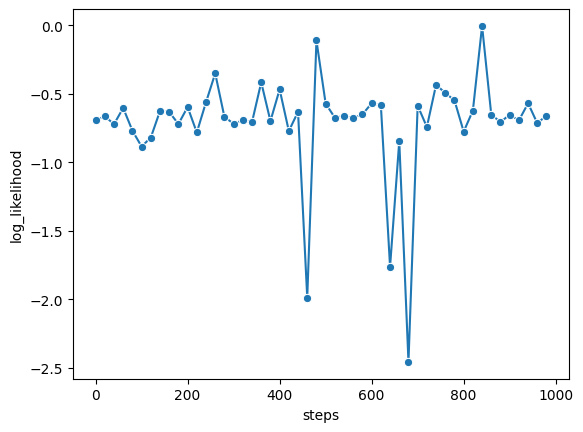

In [11]:
sns.lineplot(data=pandas.DataFrame(log_likelihoods, columns=['steps', 'log_likelihood']), x="steps", y="log_likelihood", marker="o")
plt.show()

(55002, 5186)


C:\Users\nandana\AppData\Local\Temp\ipykernel_33120\3196652572.py:3: RuntimeWarning: overflow encountered in exp
  result = 1/(1+np.exp(-x))


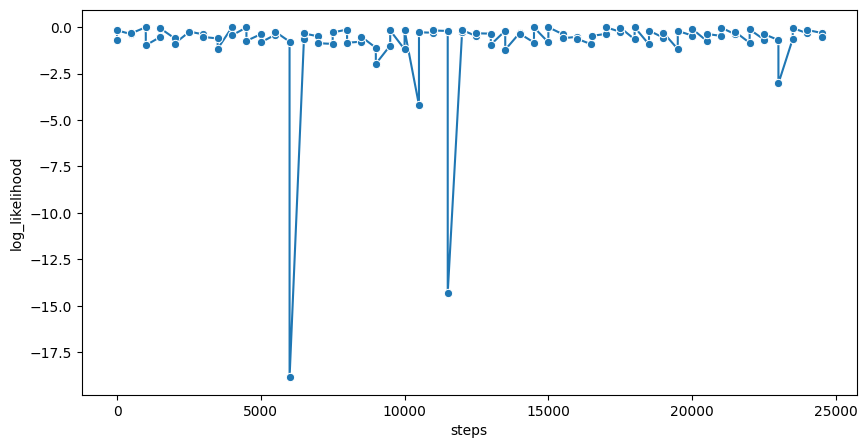

In [12]:
# running the training loop for 1000 steps
learning_rate = 5e-4
num_steps = 25000
log_likelihoods, beta_values = logistic_regression(matrix, Y_class, learning_rate, num_steps, 2, 500)
# print(log_likelihoods)
plt.figure(figsize=(10, 5))

sns.lineplot(data=pandas.DataFrame(log_likelihoods, columns=['steps', 'log_likelihood']), x="steps", y="log_likelihood", marker="o")
plt.show()

#### Validation on Validation Dataset and calculating F-1 score

In [6]:
# Function to calculate F-1 score
def calculate_f1_score(true_pos, false_neg, false_pos):
    precision = true_pos / ((true_pos + false_pos) * 1.0)
    recall = true_pos / ((true_pos + false_neg) * 1.0)
    f1 = (2 * precision * recall ) / ((precision + recall) * 1.0)
    return f1

In [14]:
df_validate = pandas.read_csv("dev.csv")
true_pos, false_pos, false_neg = 0,0,0
Y_class_validate = create_class_vector(df_validate['label'].values)
accurate = 0

for i in range(len(df_validate["generation"])):

    predicted_y = predict(df_validate["generation"].iloc[i], beta_values, indices)
    
    if predicted_y == Y_class_validate[i]:
        accurate += 1
        if predicted_y == 1:
            true_pos += 1
    else:
        if predicted_y == 0:
            false_neg += 1
        else:
            false_pos += 1

print("F1 Score: ", calculate_f1_score(true_pos, false_neg, false_pos))
accuracy = accurate / (len(df_validate) * 1.0)
print("Accuracy: ", accuracy)

F1 Score:  0.6513339466421344
Accuracy:  0.6968


#### Testing the Numpy Model

In [16]:
df_test = pandas.read_csv("test.student.csv")

with open("test_results_numpy.txt", "w") as f:
    for i in range(len(df_test["generation"])):
        predicted_y = predict(df_test["generation"].iloc[i], beta_values, indices)
        f.write(f'{df_test["id"].iloc[i]},{predicted_y}\n')

### Part 3 : Logistic Regression w Pytorch

In [7]:
# takes in sparse scipy matrix and converts it into a sparse tensor
def to_sparse_tensor(sparse_scipy):
    # return row and col indices of non zero values along with the values
    row_ind, col_ind, values = sparse.find(sparse_scipy)

    # merge both np arrays to a singular array - this is more efficient 
    indices = np.stack((row_ind, col_ind))
    i = torch.tensor(indices)
    v = torch.tensor(values, dtype=torch.float32)
    return torch.sparse_coo_tensor(i, v)

def create_eval_tensor(df_eval, tokenizer, indices):
    all_docs = []
    for i in range(len(df_eval["generation"])):
        input = df_eval["generation"].iloc[i]
        test_features = create_document_vector(input, indices, tokenizer, False)
        all_docs.append(test_features)
    
    X_eval = np.vstack(all_docs)
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)
    return X_eval_tensor
        

In [8]:
# Logistic Regression Class extending nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, vocab_size) -> None:
        # call the base class initialization
        super().__init__()
        # singular output feature for binary classification - is it LLM generated or not - predicted_y?
        # input features would be the size of the vocabulary - how many features should we train on?
        self.linear = nn.Linear(in_features = vocab_size, out_features=1)
        self.vocab_size = vocab_size
        self.sigmoid = nn.Sigmoid()

    # forward takes in input sparse matrix - documents with all features
    def forward(self, x):
        # pass the linear layer output into sigmoid function and return the probability
        x = self.linear(x)
        return self.sigmoid(x)

In [9]:
def evaluate(X_eval_tensor, Y_labels_eval, model):
    true_pos, false_pos, false_neg, accurate = 0,0,0,0
    # this disables certain behaviors
    model.eval()
    # when evaluating we need to pause certain behavior + no gradients
    with torch.no_grad():
        # predict through the model instantiated for the entire tensor
        predicted_y_values = model(X_eval_tensor)
        
        # loop through predicted y values to find true/false pos/neg values
        for i in range(len(predicted_y_values)):
            # convert probabilities to actual 0/1
            predicted_y = predicted_y_values[i] >= 0.5
            if predicted_y == Y_labels_eval[i]:
                accurate += 1
                if predicted_y == 1:
                    true_pos += 1
            else:
                if predicted_y == 0:
                    false_neg += 1
                else:
                    false_pos += 1
    f1_score = calculate_f1_score(true_pos, false_neg, false_pos)
    accuracy = accurate / (X_eval_tensor.size()[0] * 1.0)
    return f1_score, accuracy
        

In [10]:
bce_loss = nn.BCELoss()

#### Pytorch Training Loop

In [11]:
def train(model, optimizer, X_tensor, Y,  X_eval_tensor, Y_eval, num_step, epochs = 1, plot=20):
    losses_eval = []
    f1_scores = []
    for epoch in range(epochs):  # loop over the dataset multiple times   
        for i in range(num_step):
            # Switch to training mode
            model.train()
            row_ind = random.randint(0, X_tensor.size(0)-1)
            inputs = X_tensor[row_ind]
            
            label = torch.tensor([Y[row_ind]], dtype=torch.float32)
            # zero out parameter gradients - they accumulate by default in pytorch
            optimizer.zero_grad()
            # forward pass
            output = model(inputs)
            
            loss = bce_loss(output, label)
            # backward pass
            loss.backward()
            # update parameters with respect to loss
            optimizer.step()

            if i % plot == 0:
                f1_score, accuracy = evaluate(X_eval_tensor, Y_eval, model)
                each_loss = loss.item()    
                print(f'[{i}] loss: {each_loss}')
                losses_eval.append((i + epoch,each_loss))
                f1_scores.append((i + epoch,f1_score))
    
    # Print final metrics
    print(f"Final F1 Score:{f1_score}")
    print(f"Final Accuracy:{accuracy}")
    return losses_eval, f1_scores
    

In [12]:
# setting up term document matrix and class labels as a vector for training
df = pandas.read_csv("train.csv")
# create a sparse matrix for all training documents
matrix, indices = create_sparse_matrix(df["generation"], better_tokenize)

X_tensor = to_sparse_tensor(matrix)
Y_class = create_class_vector(df['label'].values)

# setting up term document matrix for evaluation
df_eval = pandas.read_csv("dev.csv")
X_eval_tensor = create_eval_tensor(df_eval, better_tokenize, indices)
Y_class_eval = create_class_vector(df_eval['label'].values)

# number of columns of feature vectors
vocab_size = matrix.shape[1]

print(X_tensor.size(), Y_class.shape)
print(X_eval_tensor.size(), Y_class_eval.shape)

torch.Size([55002, 5186]) (55002,)
torch.Size([5000, 5186]) (5000,)


In [13]:
model = LogisticRegression(vocab_size)
learning_rate = 5e-5
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Problem : Training for 1000 steps and plotting Loss

[0] loss: 0.7153912782669067
[50] loss: 0.760532796382904
[100] loss: 0.5964173674583435
[150] loss: 0.699769914150238
[200] loss: 0.6608895063400269
[250] loss: 0.9342588186264038
[300] loss: 1.9352877140045166
[350] loss: 0.6874527931213379
[400] loss: 0.6114363074302673
[450] loss: 0.7455742955207825
[500] loss: 0.8383356928825378
[550] loss: 1.02488112449646
[600] loss: 0.6529498100280762
[650] loss: 0.3939899206161499
[700] loss: 0.6492030024528503
[750] loss: 0.6700500249862671
[800] loss: 0.6726620197296143
[850] loss: 0.5937576293945312
[900] loss: 0.7097576856613159
[950] loss: 0.5768450498580933
Final F1 Score:0.6312952669698502
Final Accuracy:0.5622


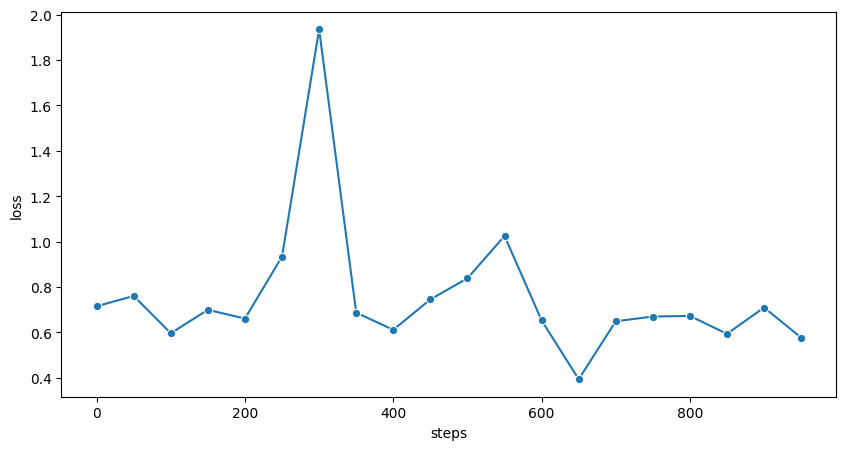

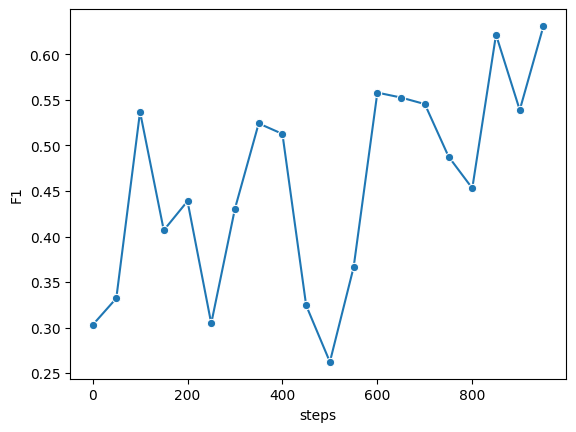

In [14]:
losses, f1_scores = train(model, optimizer, X_tensor, Y_class, X_eval_tensor, Y_class_eval, 1000, 1, 50)

plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(losses, columns=['steps', 'loss']), x="steps", y="loss", marker="o")
plt.show()

sns.lineplot(data=pandas.DataFrame(f1_scores, columns=['steps', 'F1']), x="steps", y="F1", marker="o")
plt.show()

### Weight Decay

In [22]:
learning_rate = 5e-5

model_def = LogisticRegression(vocab_size)
optimizer_def = torch.optim.SGD(model_def.parameters(), lr=learning_rate)
# 1 full epoch with default weight decay
losses_def, f1_scores_def = train(model_def, optimizer_def, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)

model_001 = LogisticRegression(vocab_size)
optimizer_001 = torch.optim.SGD(model_001.parameters(), lr=learning_rate)
# 1 full epoch with weight decay = .001
losses_001, f1_scores_001 = train(model_001, optimizer_001, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)


model_1 = LogisticRegression(vocab_size)
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=learning_rate)
# 1 full epoch with weight decay = 0.1
losses_1, f1_scores_1 = train(model_1, optimizer_1, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)


[0] loss: 0.5954203605651855
[50] loss: 0.6729382872581482
[100] loss: 0.5960339307785034
[150] loss: 0.7148804664611816
[200] loss: 0.7282201647758484
[250] loss: 0.7701464295387268
[300] loss: 0.613758385181427
[350] loss: 0.7929840087890625
[400] loss: 0.7245724201202393
[450] loss: 0.5642925500869751
[500] loss: 0.5237417221069336
[550] loss: 0.618080735206604
[600] loss: 0.7349536418914795
[650] loss: 0.7665804028511047
[700] loss: 0.6640782356262207
[750] loss: 0.8521391153335571
[800] loss: 0.33297133445739746
[850] loss: 1.5884617567062378
[900] loss: 0.6471765637397766
[950] loss: 0.6652117967605591
[1000] loss: 0.5949288010597229
[1050] loss: 0.5380473136901855
[1100] loss: 0.7548258304595947
[1150] loss: 0.745546817779541
[1200] loss: 0.6954361200332642
[1250] loss: 0.5034288167953491
[1300] loss: 0.6253225207328796
[1350] loss: 0.8614878058433533
[1400] loss: 0.6953740119934082
[1450] loss: 0.06197185441851616
[1500] loss: 1.024377465248108
[1550] loss: 1.1758121252059937
[

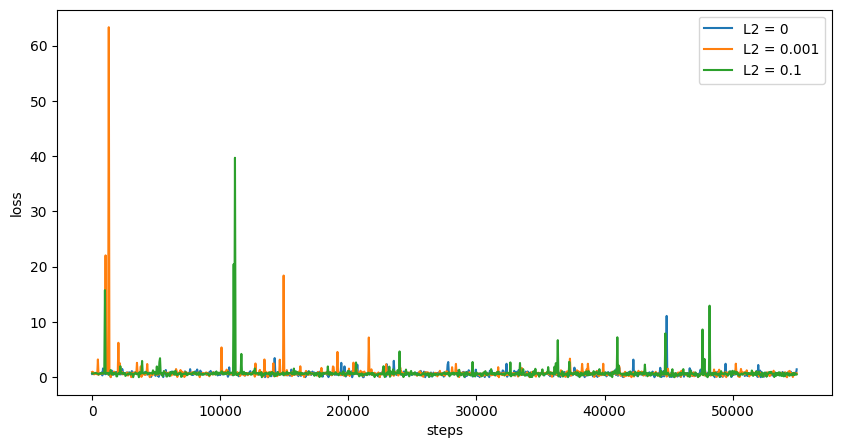

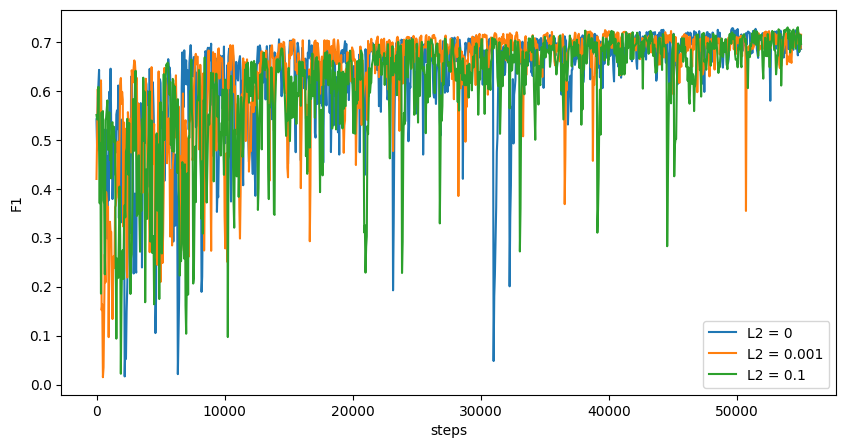

Metrics for L2 = 0
F1 Score 0.6889932611803146 Accuracy 0.6954
Metrics for L2 = 0.001
F1 Score 0.7124274564738843 Accuracy 0.7126
Metrics for L2 = 0.1
F1 Score 0.694249069093918 Accuracy 0.7044


In [24]:
# Plot Loss across different L2 regularization
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(losses_def, columns=['steps', 'loss']), x="steps", y="loss", label="L2 = 0")
sns.lineplot(data=pandas.DataFrame(losses_001, columns=['steps', 'loss']), x="steps", y="loss", label="L2 = 0.001")
sns.lineplot(data=pandas.DataFrame(losses_1, columns=['steps', 'loss']), x="steps", y="loss", label="L2 = 0.1")
plt.show()

# Plot F1 across different L2 regularization
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(f1_scores_def, columns=['steps', 'F1']), x="steps", y="F1", label="L2 = 0")
sns.lineplot(data=pandas.DataFrame(f1_scores_001, columns=['steps', 'F1']), x="steps", y="F1", label="L2 = 0.001")
sns.lineplot(data=pandas.DataFrame(f1_scores_1, columns=['steps', 'F1']), x="steps", y="F1", label="L2 = 0.1")
plt.show()

# Compute Final F1 score for each model
print("Metrics for L2 = 0")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_def)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

print("Metrics for L2 = 0.001")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_001)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

print("Metrics for L2 = 0.1")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_1)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

### Effect of Different Optimizers

In [26]:
model_sgd = LogisticRegression(vocab_size)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=learning_rate)
# 1 full epoch with default SGD optimizer
losses_sgd, f1_scores_sgd = train(model_sgd, optimizer_sgd, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)

model_adam = LogisticRegression(vocab_size)
optimizer_adam = torch.optim.AdamW(model_adam.parameters(), lr=learning_rate)
# 1 full epoch with AdamW optmizer
losses_adam, f1_scores_adam = train(model_adam, optimizer_adam, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)

model_rms = LogisticRegression(vocab_size)
optimizer_rms = torch.optim.RMSprop(model_rms.parameters(), lr=learning_rate)
# 1 full epoch with RMSprop optimizer
losses_rms, f1_scores_rms = train(model_rms, optimizer_rms, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)


[0] loss: 0.5677598118782043
[50] loss: 0.5446071624755859
[100] loss: 0.7873185276985168
[150] loss: 0.8074947595596313
[200] loss: 0.700739324092865
[250] loss: 0.6787313222885132
[300] loss: 0.7574545741081238
[350] loss: 0.6040310263633728
[400] loss: 0.6696276068687439
[450] loss: 0.5163939595222473
[500] loss: 0.9288848042488098
[550] loss: 0.6567939519882202
[600] loss: 0.6461711525917053
[650] loss: 0.5151436924934387
[700] loss: 0.5953497290611267
[750] loss: 0.6071932911872864
[800] loss: 0.9299262762069702
[850] loss: 1.1205326318740845
[900] loss: 0.9678857922554016
[950] loss: 0.700831413269043
[1000] loss: 0.8165560364723206
[1050] loss: 0.6431498527526855
[1100] loss: 0.6930462121963501
[1150] loss: 0.5816384553909302
[1200] loss: 0.5996198058128357
[1250] loss: 0.7690132856369019
[1300] loss: 0.5239298939704895
[1350] loss: 0.7609096169471741
[1400] loss: 0.8080036640167236
[1450] loss: 0.048886045813560486
[1500] loss: 0.8514018058776855
[1550] loss: 0.7754520177841187

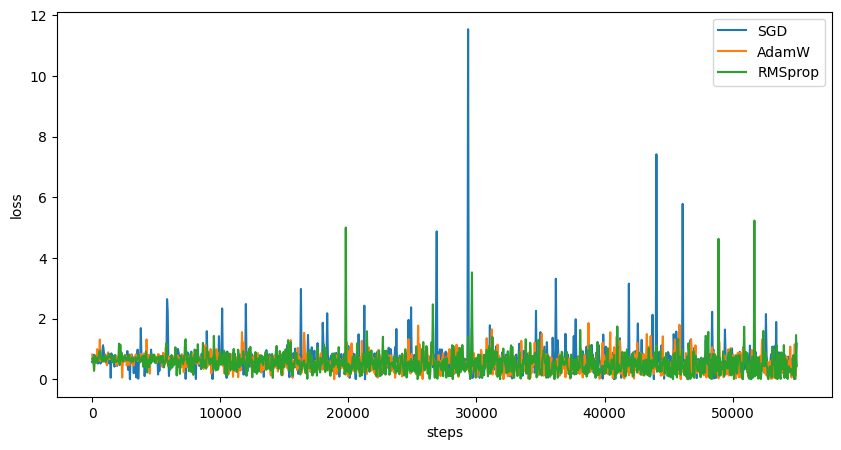

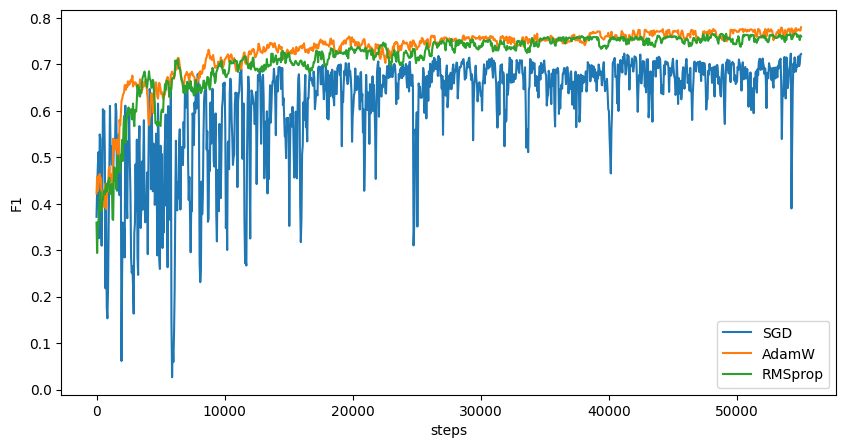

Metrics for SGD
F1 Score 0.7222019686474662 Accuracy 0.6952
Metrics for AdamW
F1 Score 0.7797302819779321 Accuracy 0.7844
Metrics for RMSprop
F1 Score 0.7599591419816139 Accuracy 0.765


In [28]:
# Plot Loss across different Optimizers
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(losses_sgd, columns=['steps', 'loss']), x="steps", y="loss", label="SGD")
sns.lineplot(data=pandas.DataFrame(losses_adam, columns=['steps', 'loss']), x="steps", y="loss", label="AdamW")
sns.lineplot(data=pandas.DataFrame(losses_rms, columns=['steps', 'loss']), x="steps", y="loss", label="RMSprop")
plt.show()

# Plot F1 Scores across different Optimizers
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(f1_scores_sgd, columns=['steps', 'F1']), x="steps", y="F1", label="SGD")
sns.lineplot(data=pandas.DataFrame(f1_scores_adam, columns=['steps', 'F1']), x="steps", y="F1", label="AdamW")
sns.lineplot(data=pandas.DataFrame(f1_scores_rms, columns=['steps', 'F1']), x="steps", y="F1", label="RMSprop")
plt.show()

# Compute F1 score for each model
print("Metrics for SGD")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_sgd)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

print("Metrics for AdamW")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_adam)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

print("Metrics for RMSprop")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_rms)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

### Effect of Different Tokenizers

In [31]:
learning_rate = 5e-5
bce_loss = nn.BCELoss()

model_better_tokenizer = LogisticRegression(vocab_size)
optimizer_better_tokenizer = torch.optim.SGD(model_better_tokenizer.parameters(), lr=learning_rate)
# 1 full epoch with better tokenizer
losses_better, f1_scores_better = train(model_better_tokenizer, optimizer_better_tokenizer, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)

# create a sparse matrix for all training documents using basic tokenizer
matrix_basic_tokenize, indices_basic_tokenize = create_sparse_matrix(df["generation"], tokenize)
X_tensor_basic = to_sparse_tensor(matrix_basic_tokenize)
X_eval_tensor_basic = create_eval_tensor(df_eval, tokenize, indices_basic_tokenize)

basic_vocab_size = matrix_basic_tokenize.shape[1]
model_basic_tokenizer = LogisticRegression(basic_vocab_size)
optimizer_basic_tokenizer = torch.optim.SGD(model_basic_tokenizer.parameters(), lr=learning_rate)

# 1 full epoch with better tokenizer
losses_basic, f1_scores_basic = train(model_basic_tokenizer, optimizer_basic_tokenizer, X_tensor_basic, Y_class, X_eval_tensor_basic, Y_class_eval, X_tensor_basic.size()[0], 1, 50)


[0] loss: 0.6027565002441406
[50] loss: 0.6541023850440979
[100] loss: 0.7495785355567932
[150] loss: 0.7282629013061523
[200] loss: 0.2674110531806946
[250] loss: 0.5968250036239624
[300] loss: 0.6929479241371155
[350] loss: 0.7520391345024109
[400] loss: 0.6069124937057495
[450] loss: 0.26029518246650696
[500] loss: 0.10361691564321518
[550] loss: 0.20718859136104584
[600] loss: 0.8609519004821777
[650] loss: 0.6499043107032776
[700] loss: 1.7106090784072876
[750] loss: 0.6443628668785095
[800] loss: 0.42720648646354675
[850] loss: 0.48103654384613037
[900] loss: 0.6808558106422424
[950] loss: 0.9258617758750916
[1000] loss: 0.7511551976203918
[1050] loss: 0.7256982922554016
[1100] loss: 0.809301495552063
[1150] loss: 0.6980074644088745
[1200] loss: 0.8071715831756592
[1250] loss: 0.5684195756912231
[1300] loss: 0.6133939623832703
[1350] loss: 0.6277586221694946
[1400] loss: 0.8891512751579285
[1450] loss: 0.7077007293701172
[1500] loss: 0.9414658546447754
[1550] loss: 0.616265118122

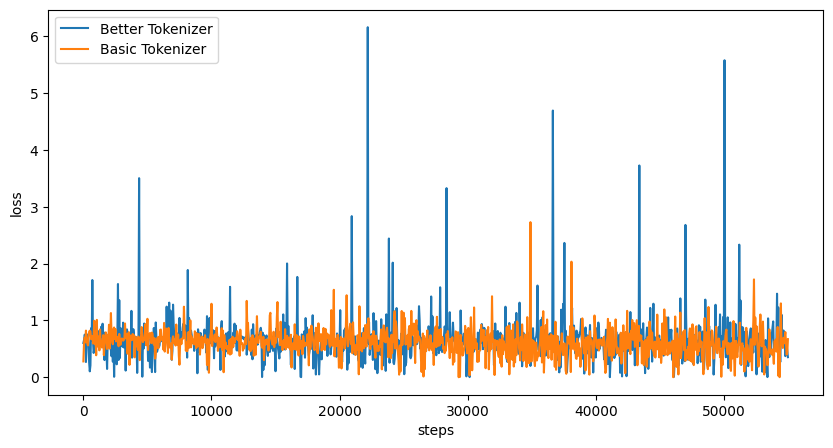

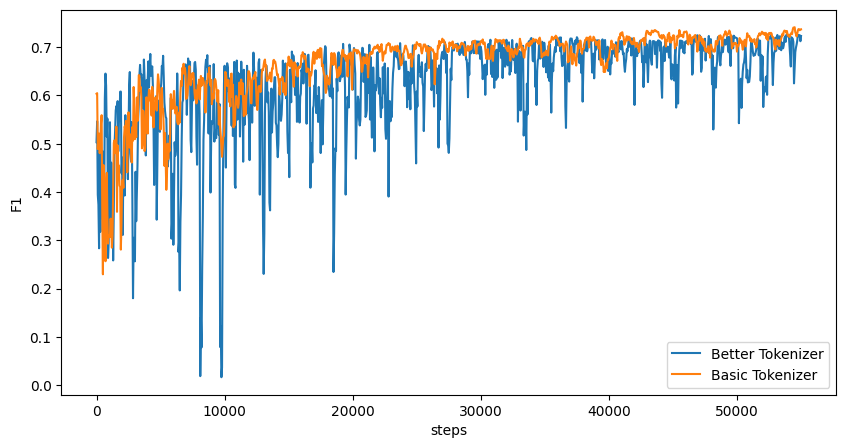

Metrics for Better Tokenizer
F1 Score 0.7239618788291354 Accuracy 0.6756
Metrics for Basic Tokenizer
F1 Score 0.7372408293460926 Accuracy 0.7364


In [34]:
# Plot Loss across different Tokenizers
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(losses_better, columns=['steps', 'loss']), x="steps", y="loss", label="Better Tokenizer")
sns.lineplot(data=pandas.DataFrame(losses_basic, columns=['steps', 'loss']), x="steps", y="loss", label="Basic Tokenizer")
plt.show()

# Plot F1 Scores across different Tokenizers
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(f1_scores_better, columns=['steps', 'F1']), x="steps", y="F1", label="Better Tokenizer")
sns.lineplot(data=pandas.DataFrame(f1_scores_basic, columns=['steps', 'F1']), x="steps", y="F1", label="Basic Tokenizer")
plt.show()

# Compute F1 score for each model
print("Metrics for Better Tokenizer")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_better_tokenizer)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

print("Metrics for Basic Tokenizer")
f1_score, accuracy = evaluate(X_eval_tensor_basic, Y_class_eval, model_basic_tokenizer)
print(f"F1 Score {f1_score} Accuracy {accuracy}")


### Effect of Different Learning Rates

In [35]:
learning_rate_def = 5e-5
learning_rate_small = 5e-7
learning_rate_large = 5e-3

model_def = LogisticRegression(vocab_size)
optimizer_def = torch.optim.SGD(model_def.parameters(), lr=learning_rate_def)
# 1 full epoch with default learning rate
losses_def, f1_scores_def = train(model_def, optimizer_def, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)

model_small = LogisticRegression(vocab_size)
optimizer_small = torch.optim.SGD(model_small.parameters(), lr=learning_rate_small)
# 1 full epoch with much smaller learning rate
losses_small, f1_scores_small = train(model_small, optimizer_small, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)

model_large = LogisticRegression(vocab_size)
optimizer_large = torch.optim.SGD(model_large.parameters(), lr=learning_rate_large)
# 1 full epoch with much larger learning rate
losses_large, f1_scores_large = train(model_large, optimizer_large, X_tensor, Y_class, X_eval_tensor, Y_class_eval, X_tensor.size()[0], 1, 50)

[0] loss: 0.884823203086853
[50] loss: 0.6471724510192871
[100] loss: 0.8213683366775513
[150] loss: 0.6470737457275391
[200] loss: 0.9173899292945862
[250] loss: 0.7032179832458496
[300] loss: 0.6434491872787476
[350] loss: 0.6912220120429993
[400] loss: 0.7736631631851196
[450] loss: 0.6283273100852966
[500] loss: 0.8008473515510559
[550] loss: 0.4181979298591614
[600] loss: 0.5770271420478821
[650] loss: 0.6962811946868896
[700] loss: 0.8421333432197571
[750] loss: 0.6253251433372498
[800] loss: 0.7179417610168457
[850] loss: 0.7238695621490479
[900] loss: 0.5812920331954956
[950] loss: 0.6892099380493164
[1000] loss: 0.6542434692382812
[1050] loss: 0.5841706991195679
[1100] loss: 0.6782925128936768
[1150] loss: 1.6829971075057983
[1200] loss: 0.5397253632545471
[1250] loss: 0.7354409098625183
[1300] loss: 0.5245962142944336
[1350] loss: 0.6768561601638794
[1400] loss: 0.6240943074226379
[1450] loss: 0.6236845254898071
[1500] loss: 0.7234143614768982
[1550] loss: 0.4449149966239929


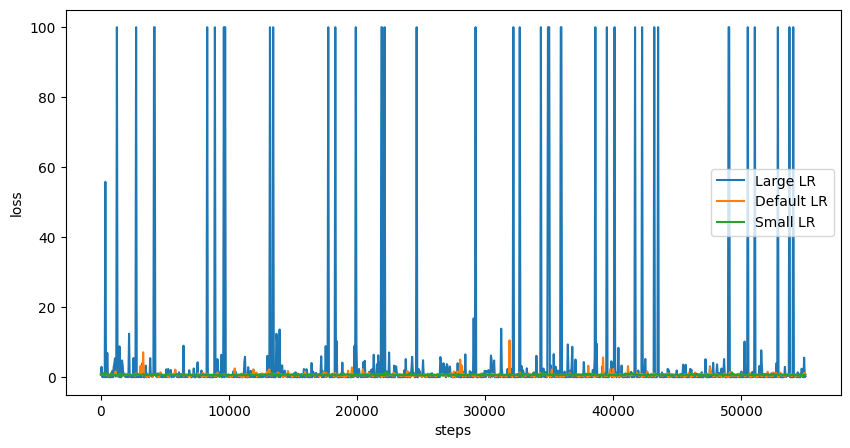

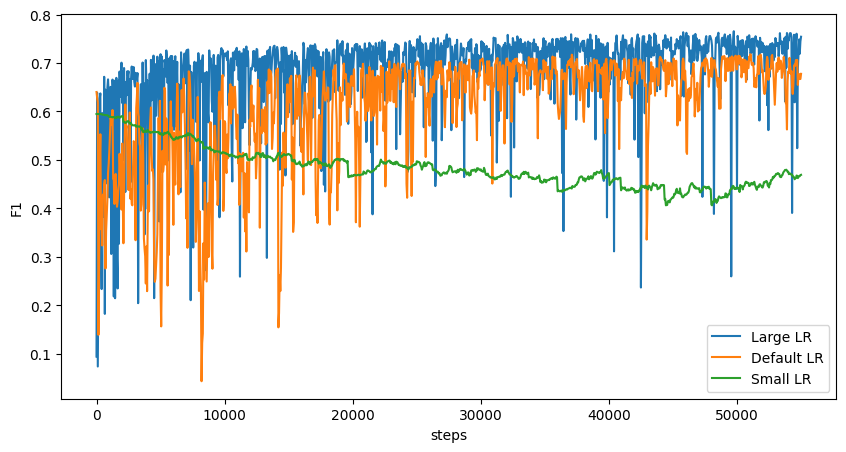

Metrics for Default LR
F1 Score 0.6776525979485455 Accuracy 0.6166
Metrics for Small LR
F1 Score 0.46964856230031954 Accuracy 0.5352
Metrics for Large LR
F1 Score 0.7541431078182882 Accuracy 0.7478


In [38]:
# Plot Loss across different learning rates
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(losses_large, columns=['steps', 'loss']), x="steps", y="loss", label="Large LR")
sns.lineplot(data=pandas.DataFrame(losses_def, columns=['steps', 'loss']), x="steps", y="loss", label="Default LR")
sns.lineplot(data=pandas.DataFrame(losses_small, columns=['steps', 'loss']), x="steps", y="loss", label="Small LR")
plt.show()

# Plot F1 Scores across different learning rates
plt.figure(figsize=(10, 5))
sns.lineplot(data=pandas.DataFrame(f1_scores_large, columns=['steps', 'F1']), x="steps", y="F1", label="Large LR")
sns.lineplot(data=pandas.DataFrame(f1_scores_def, columns=['steps', 'F1']), x="steps", y="F1", label="Default LR")
sns.lineplot(data=pandas.DataFrame(f1_scores_small, columns=['steps', 'F1']), x="steps", y="F1", label="Small LR")
plt.show()

# Compute F1 score for each model
print("Metrics for Default LR")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_def)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

print("Metrics for Small LR")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_small)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

print("Metrics for Large LR")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_large)
print(f"F1 Score {f1_score} Accuracy {accuracy}")

### Best Model - Predicting Results for Kaggle

In [40]:
# setting up term document matrix for evaluation
df_test = pandas.read_csv("test.student.csv")
X_test_tensor = create_eval_tensor(df_test, better_tokenize, indices)

with open("test_results_pytorch.txt", "w") as f:
    model_adam.eval()
    # when evaluating we need to pause certain behavior + no gradients
    with torch.no_grad():
        # predict through the model instantiated for the entire tensor
        predicted_y_values = model_adam(X_test_tensor)
        # loop through predicted y values to write to file
        for i in range(len(predicted_y_values)):
            # convert probabilities to actual 0/1
            predicted_y = predicted_y_values[i] >= 0.5
            f.write(f'{df_test["id"].iloc[i]},{predicted_y.item()}\n')

print("Metrics for AdamW - Highest F1 Scores")
f1_score, accuracy = evaluate(X_eval_tensor, Y_class_eval, model_adam)
print(f"F1 Score {f1_score}\nAccuracy {accuracy}")

Metrics for AdamW - Highest F1 Scores
F1 Score 0.7797302819779321
Accuracy 0.7844


### Most Important Features Learnt

In [37]:
def find_highest_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights = param.tolist()

    weights = weights[0]
    # convert all values into absolute because magnitude is what matters
    for i in range(len(weights)):
        weights[i] = abs(weights[i])

    # get index positions to identify features
    weights = list(enumerate(weights))

    weights.sort(key=lambda x: x[1], reverse=True)
    print(weights[:10])